In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv("stocks/A.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Use Close price
prices = df["Close"].values.reshape(-1, 1)

# Scaling
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 20
X, y = create_sequences(prices_scaled, SEQ_LEN)

# Train/validation split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


In [4]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)



In [7]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    train_pred = model(X_train)
    train_loss = criterion(train_pred, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}: "
          f"Train MSE={train_loss.item():.4f}, "
          f"Val MSE={val_loss.item():.4f}")


Epoch 1: Train MSE=0.0319, Val MSE=0.2003
Epoch 2: Train MSE=0.0193, Val MSE=0.1560
Epoch 3: Train MSE=0.0122, Val MSE=0.1190
Epoch 4: Train MSE=0.0105, Val MSE=0.0925
Epoch 5: Train MSE=0.0125, Val MSE=0.0789
Epoch 6: Train MSE=0.0146, Val MSE=0.0754
Epoch 7: Train MSE=0.0149, Val MSE=0.0783
Epoch 8: Train MSE=0.0135, Val MSE=0.0852
Epoch 9: Train MSE=0.0117, Val MSE=0.0941
Epoch 10: Train MSE=0.0102, Val MSE=0.1037
Epoch 11: Train MSE=0.0093, Val MSE=0.1126
Epoch 12: Train MSE=0.0091, Val MSE=0.1198
Epoch 13: Train MSE=0.0094, Val MSE=0.1243
Epoch 14: Train MSE=0.0097, Val MSE=0.1260
Epoch 15: Train MSE=0.0099, Val MSE=0.1247
Epoch 16: Train MSE=0.0098, Val MSE=0.1208
Epoch 17: Train MSE=0.0095, Val MSE=0.1147
Epoch 18: Train MSE=0.0090, Val MSE=0.1069
Epoch 19: Train MSE=0.0083, Val MSE=0.0982
Epoch 20: Train MSE=0.0078, Val MSE=0.0892


In [11]:
from sklearn.metrics import mean_squared_error

model.eval()
with torch.no_grad():
    preds = model(X_val).numpy()
    true = y_val.numpy()

# Inverse scaling
preds = scaler.inverse_transform(preds)
true = scaler.inverse_transform(true)

rmse = np.sqrt(mean_squared_error(true, preds))
print("RMSE:", rmse)


RMSE: 31.649720914794415


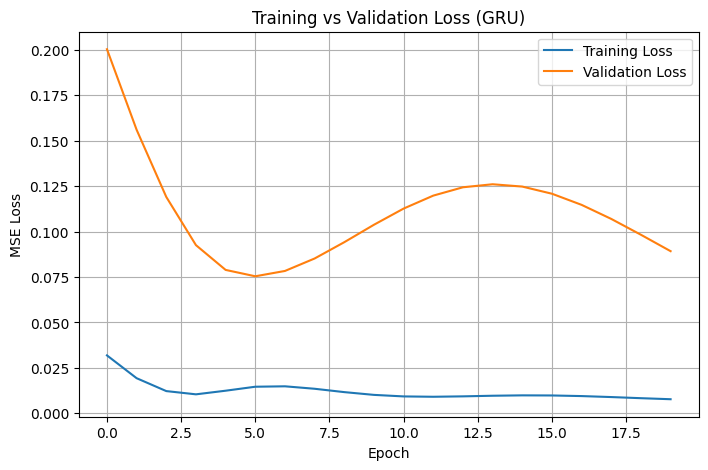

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (GRU)")
plt.legend()
plt.grid(True)
plt.show()


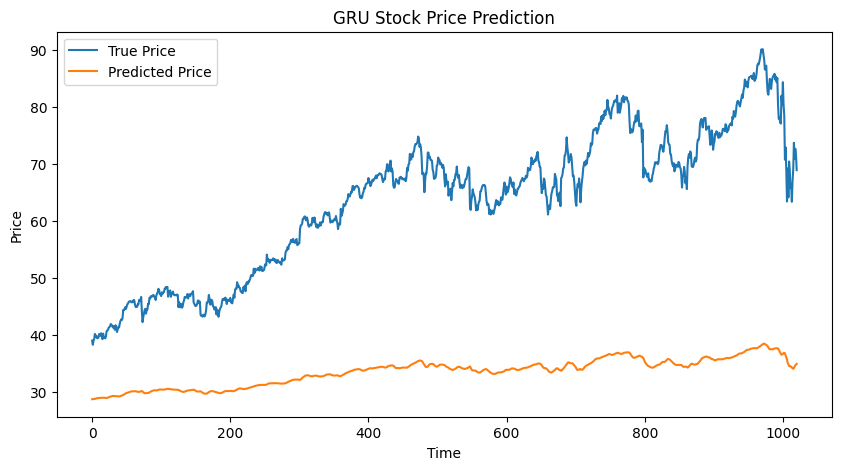

In [9]:
model.eval()
with torch.no_grad():
    preds = model(X_val).numpy()
    true = y_val.numpy()

preds = scaler.inverse_transform(preds)
true = scaler.inverse_transform(true)

plt.figure(figsize=(10,5))
plt.plot(true, label="True Price")
plt.plot(preds, label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("GRU Stock Price Prediction")
plt.legend()
plt.show()
